**Unsupervised Learning Trading Strategy**
Download/Load SP500 stocks prices data.

Calculate different features and indicators on each stocks

Aggregate on monthly level and filter top 150 most liquid stocks.

Calculate Monthly Returns for different time-horizons.

Download Fama-French Factors and Calculate Rolling Factor Betas.

For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.

Visualize Portfolio returns and compare to SP500 returns.

**All Packages Needed:**
*# pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt *

In [ ]:
!pip install numpy==1.26.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 121.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install pandas_ta

## 1. Download/Load SP500 stocks prices data.

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import requests
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# 1. Get S&P 500 tickers safely
# -------------------------------
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

response = requests.get(url, headers=headers)
sp500 = pd.read_html(response.text)[0]

# Fix tickers for yfinance
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-', regex=False)
symbols_list = sp500['Symbol'].tolist()

# -------------------------------
# 2. Set date range
# -------------------------------
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

# -------------------------------
# 3. Download data from Yahoo Finance
# -------------------------------
df = yf.download(
    tickers=symbols_list,
    start=start_date,
    end=end_date,
    auto_adjust=False,   # Do not adjust for splits/dividends
    group_by='ticker',   # Returns ticker-level grouping
    threads=True
)

# -------------------------------
# 4. Stack MultiIndex columns for easier handling
# -------------------------------
# Some tickers may not have data; keep only tickers with 'Adj Close'
available_tickers = [t for t in symbols_list if ('Adj Close' in df[t])]
df = df[available_tickers]

# Stack on ticker level
df = df.stack(level=0)
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

# -------------------------------
# 5. Quick preview
# -------------------------------
df.head()


[*********************100%***********************]  504 of 504 completed
ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['VLTO', 'SOLV', 'GEV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-27 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443326400, endDate = 1695787200")')


Price                   open       high        low      close  adj close  \
date       ticker                                                          
2015-09-28 A       34.130001  34.270000  33.320000  33.369999  30.843346   
           AAPL    28.462500  28.642500  28.110001  28.110001  25.268145   
           ABBV    55.389999  55.430000  52.340000  52.500000  34.570026   
           ABT     40.740002  40.740002  39.000000  39.060001  32.310116   
           ACGL    24.056667  24.243334  23.966667  24.180000  22.992727   

Price                   volume  
date       ticker               
2015-09-28 A         2615400.0  
           AAPL    208436000.0  
           ABBV     15123000.0  
           ABT      17219300.0  
           ACGL      1946700.0

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [ ]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                    open        high         low       close   adj close  \
date       ticker                                                               
2015-09-28 A        34.130001   34.270000   33.320000   33.369999   30.843346   
           AAPL     28.462500   28.642500   28.110001   28.110001   25.268145   
           ABBV     55.389999   55.430000   52.340000   52.500000   34.570026   
           ABT      40.740002   40.740002   39.000000   39.060001   32.310116   
           ACGL     24.056667   24.243334   23.966667   24.180000   22.992727   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.939999   45.740002   44.560001   44.810001   44.810001   
           YUM     124.239998  124.739998  123.449997  124.010002  119.860718   
           ZBH     116.769997  117.110001  112.419998  112.459999  110.513565   
           ZBRA    225.970001  226.649994  222.580002  223.960007  223.960007   
           ZTS     176.580002  178.449997  176.270004  176.869995  173.026093   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-28 A         2615400.0         -0.003565        NaN       NaN   
           AAPL    208436000.0         -0.005298        NaN       NaN   
           ABBV     15123000.0         -0.084201        NaN       NaN   
           ABT      17219300.0         -0.019809        NaN       NaN   
           ACGL      1946700.0         -0.000725        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYZ      10168200.0          0.000338  25.939817  3.799574   
           YUM       1500600.0         -0.000443  36.057146  4.792448   
           ZBH       3610500.0         -0.000336  31.893225  4.736766   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0         -0.000084  42.623423  5.141724   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-28 A            NaN       NaN       NaN       NaN      80.667686  
           AAPL         NaN       NaN       NaN       NaN    5266.790989  
           ABBV         NaN       NaN       NaN       NaN     522.802509  
           ABT          NaN       NaN       NaN       NaN     556.357577  
           ACGL         NaN       NaN       NaN       NaN      44.759942  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYZ     3.980555  4.161536 -0.637443 -0.990293     455.637056  
           YUM     4.822408  4.852369  0.142517 -1.363306     179.862993  
           ZBH     4.776429  4.816093 -0.381346 -0.881471     399.009227  
           ZBRA    5.539167  5.677342 -0.056874 -1.601131      79.595386  
           ZTS     5.200533  5.259341  0.651965 -1.188423     253.171779  

[983629 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          134.704649   38.653542         -0.002562  73.544044   
           AAPL      4000.711995   26.698833         -0.003741  54.676790   
           ABBV       322.941669   38.643803         -0.073821  49.466806   
           ABT        206.572090   37.373245         -0.014661  57.239063   
           ACGL        28.174423   22.970539         -0.001121  36.396398   
...                          ...         ...               ...        ...   
2023-09-30 EXE        114.919889   78.073814         -0.000856  44.326466   
           COIN       506.942443   70.519997          0.001007  39.839731   
           CEG        195.128964  107.016655         -0.000103  55.245481   
           GEHC       211.835316   65.992218          0.000182  40.922306   
           KVUE       640.357004   19.098040         -0.002025  35.706333   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.536749  3.609179  3.681609 -1.033382  0.568320  
           AAPL    3.276097  3.319400  3.362702 -0.965970 -0.151141  
           ABBV    3.683500  3.731698  3.779896 -0.524698  0.125473  
           ABT     3.632364  3.654204  3.676044 -1.063278  0.333750  
           ACGL    3.177974  3.195190  3.212406 -1.154844 -0.531364  
...                     ...       ...       ...       ...       ...  
2023-09-30 EXE     4.354349  4.407848  4.461346 -1.067686 -0.831788  
           COIN    4.273572  4.378785  4.483998 -1.183735  0.049978  
           CEG     4.644354  4.684524  4.724694 -0.436215  0.366876  
           GEHC    4.153380  4.210914  4.268448 -0.893478 -1.116463  
           KVUE    2.970144  3.044930  3.119715 -0.899746 -1.435618  

[46422 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.060883         -0.002842  49.891097  3.288653   
           ABBV     38.501831         -0.059393  27.477827  3.710224   
           ABT      33.469265         -0.010344  38.008828  3.531008   
           ACN     101.253777         -0.006765  53.823722  4.614949   
           ADBE    107.510002          0.000059  53.668387  4.679513   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.476874   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           DASH     74.580002          0.000326  36.955365  4.329191   
           ABNB    132.279999          0.000213  44.494127  4.857047   
           COIN     70.519997          0.001007  39.839731  4.273572   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.317526  3.346400 -1.038461 -0.195865  
           ABBV    3.764332  3.818440 -0.893043 -0.760499  
           ABT     3.581448  3.631888 -1.035050 -0.651383  
           ACN     4.626584  4.638219 -0.996294 -0.136004  
           ADBE    4.694639  4.709766 -1.229683 -0.109121  
...                     ...       ...       ...       ...  
2023-09-30 DDOG    4.560278  4.643681 -0.867969 -0.699392  
           PLTR    2.779743  2.857548 -0.426167 -0.433581  
           DASH    4.403906  4.478620 -1.145418 -0.117919  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  
           COIN    4.378785  4.483998 -1.183735  0.049978  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.484219         -0.001316  69.196666  3.589090   
           ABBV     64.567642         -0.044945  55.247898  4.153099   
           ABT      47.327908         -0.007607  53.844986  3.868742   
           ACN     126.506294         -0.005890  69.365209  4.780248   
           ADBE    175.160004          0.000067  70.089317  4.951759   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.476874   
           PLTR     13.960000          0.000214  41.544692  2.701939   
           DASH     74.580002          0.000326  36.955365  4.329191   
           ABNB    132.279999          0.000213  44.494127  4.857047   
           COIN     70.519997          0.001007  39.839731  4.273572   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.635955  3.682820 -0.906398 -0.039126   0.096807   
           ABBV    4.199430  4.245761  0.375915  0.474521   0.022728   
           ABT     3.892300  3.915859 -1.039871  0.275618   0.021276   
           ACN     4.819920  4.859593 -0.986001  0.351864   0.064180   
           ADBE    5.089292  5.226825 -0.887645  0.612200   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 DDOG    4.560278  4.643681 -0.867969 -0.699392  -0.102716   
           PLTR    2.779743  2.857548 -0.426167 -0.433581  -0.068091   
           DASH    4.403906  4.478620 -1.145418 -0.117919  -0.113515   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   
           COIN    4.378785  4.483998 -1.183735  0.049978  -0.114070   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 DDOG    -0.138786  -0.041732   0.029624   0.018352   -0.002098  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           DASH    -0.093658  -0.008091   0.027006   0.048207    0.034568  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  
           COIN    -0.154340  -0.004822   0.007147   0.079010    0.007477  

[10320 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096807
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021276
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 WDAY   -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.000676
           XOM    -0.0523 -0.0178  0.0149  0.0187 -0.0077   0.046947
           XYZ    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.222723

[10320 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096807
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021276
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 WDAY   -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.062413
           WFC    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.015500
           WMT    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.000676
           XOM    -0.0523 -0.0178  0.0149  0.0187 -0.0077   0.046947
           XYZ    -0.0523 -0.0178  0.0149  0.0187 -0.0077  -0.222723

[10301 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 WDAY    1.080889 -0.943888 -0.563591 -0.904332 -0.245654
           WFC     1.122064  0.240833  2.052974 -0.498805 -1.544764
           WMT     0.703877 -0.314958 -0.404472 -0.145430  0.500271
           XOM     0.983369 -1.133543  1.727320 -0.688368 -0.355507
           XYZ     2.417771  1.930175 -0.346912 -1.674851  0.482785

[10301 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10068 entries, (Timestamp('2017-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'DDOG')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10068 non-null  float64
 1   rsi               10068 non-null  float64
 2   bb_low            10068 non-null  float64
 3   bb_mid            10068 non-null  float64
 4   bb_high           10068 non-null  float64
 5   atr               10068 non-null  float64
 6   macd              10068 non-null  float64
 7   return_1m         10068 non-null  float64
 8   return_2m         10068 non-null  float64
 9   return_3m         10068 non-null  float64
 10  return_6m         10068 non-null  float64
 11  return_9m         10068 non-null  float64
 12  return_12m        10068 non-null  float64
 13  Mkt-RF            10068 non-null  float64
 14  SMB               10068 non-null  float64
 15  HML      

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [ ]:
from sklearn.cluster import KMeans

# Safely remove 'cluster' column if it exists
data = data.drop('cluster', axis=1, errors='ignore')

# Define feature columns to use in clustering
features = ['macd', 'atr', 'bb_high', 'bb_mid', 'bb_low', 'rsi', 'return_1m']  # adjust based on your data

def get_clusters(df):
    df = df.copy()
    df['cluster'] = KMeans(
        n_clusters=4,
        random_state=0,
        init='k-means++'
    ).fit(df[features]).labels_
    return df

# Apply clustering per month
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data.head()


garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAPL           -0.001316  69.196666  3.589090  3.635955  3.682820   
           ABBV           -0.044945  55.247898  4.153099  4.199430  4.245761   
           ABT            -0.007607  53.844986  3.868742  3.892300  3.915859   
           ACN            -0.005890  69.365209  4.780248  4.819920  4.859593   
           ADBE            0.000067  70.089317  4.951759  5.089292  5.226825   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906398 -0.039126   0.096807   0.015250   0.044955   
           ABBV    0.375915  0.474521   0.022728   0.098590   0.091379   
           ABT    -1.039871  0.275618   0.021276   0.034308   0.034801   
           ACN    -0.986001  0.351864   0.064180   0.048455   0.037203   
           ADBE   -0.887645  0.612200   0.174152   0.062497   0.061392   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276569 -0.251246   
           ABBV     0.056495   0.047273    0.044026  0.505457  0.360916   
           ABT      0.038672   0.031320    0.029294  0.833394 -0.194764   
           ACN      0.028692   0.027398    0.018728  1.203811 -0.154553   
           ADBE     0.045993   0.049515    0.041515  1.109843 -0.318357   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.610474  0.680494  0.488772        1  
           ABBV   -0.030512  0.179044  0.188218        3  
           ABT    -0.528555  0.255644  0.985793        3  
           ACN    -0.339661  0.270190  0.196833        1  
           ADBE   -0.184547 -0.218160 -0.687488        1

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


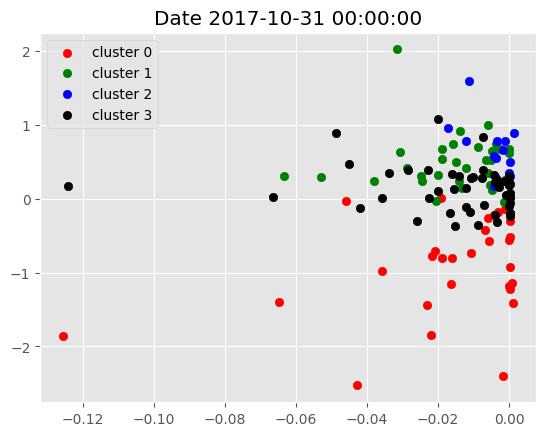

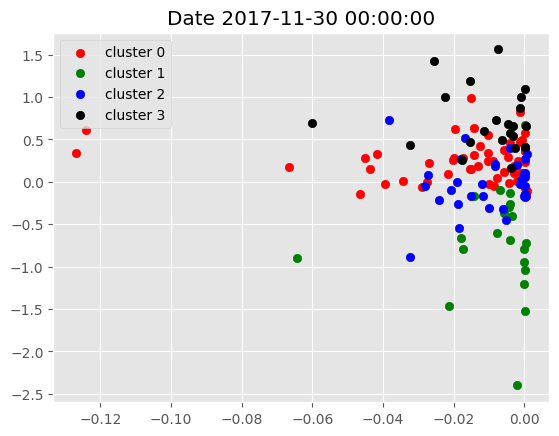

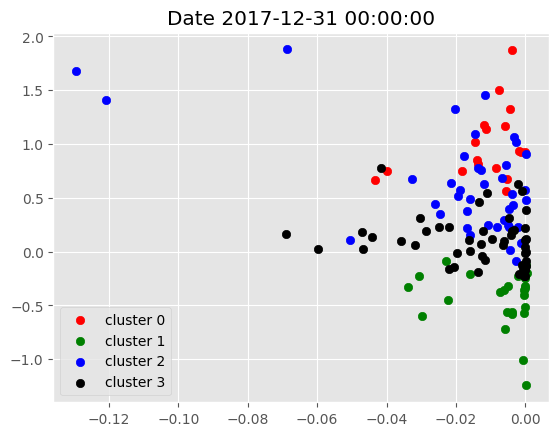

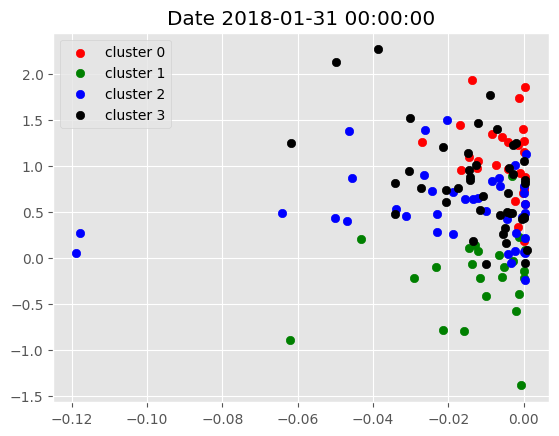

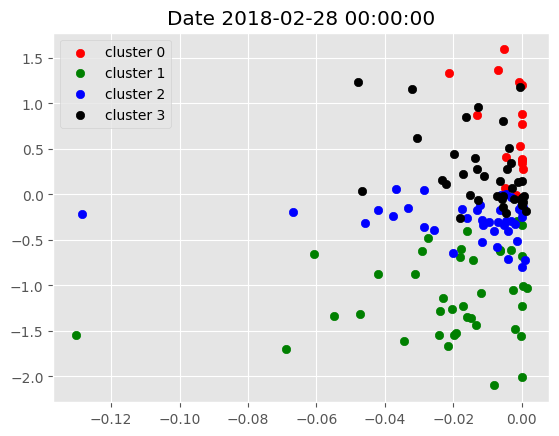

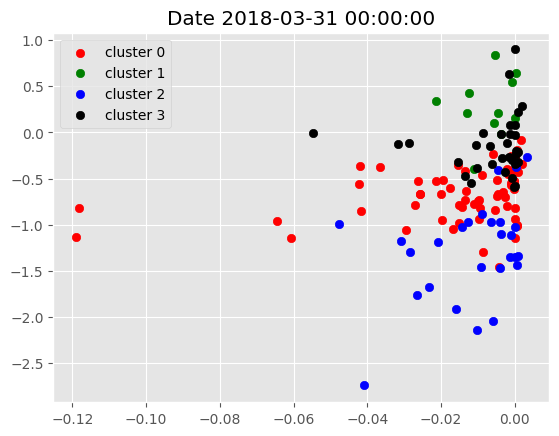

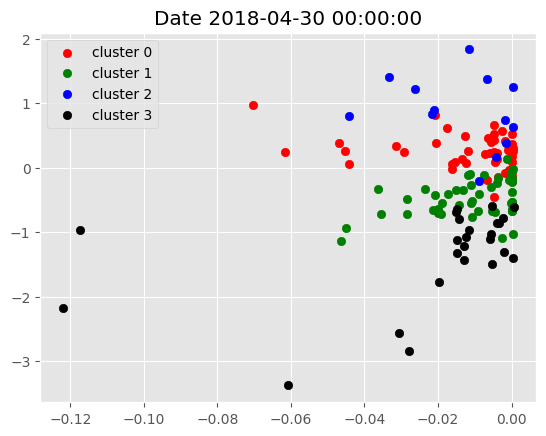

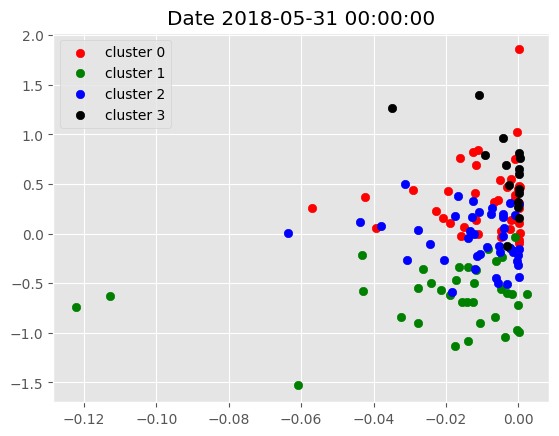

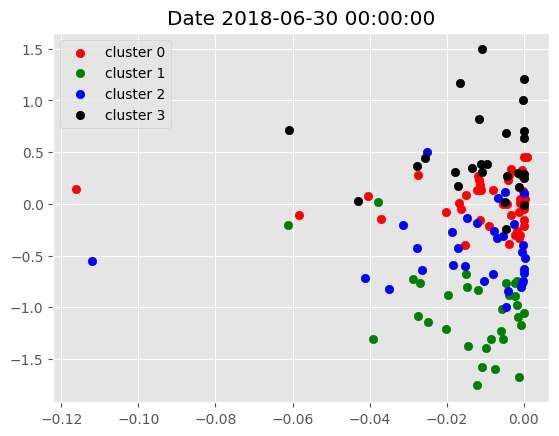

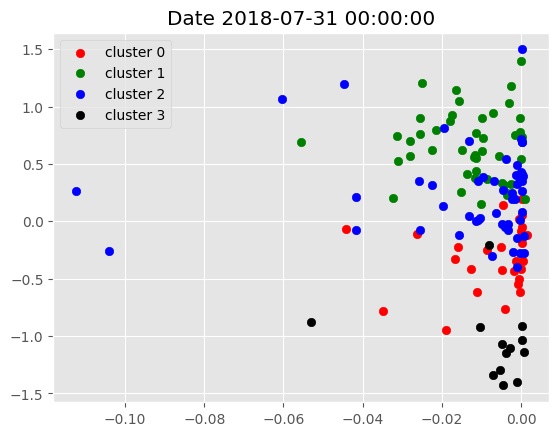

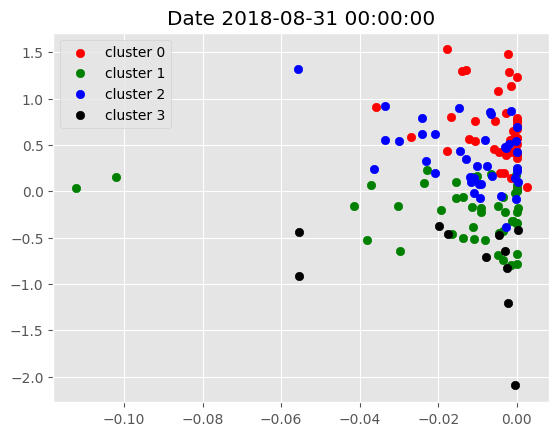

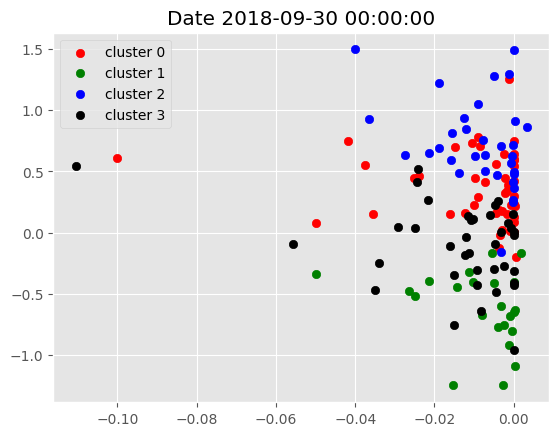

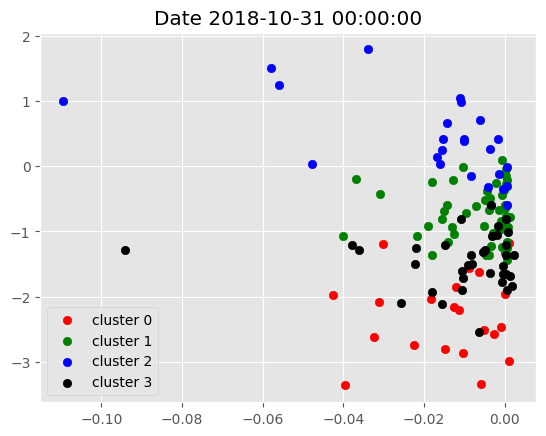

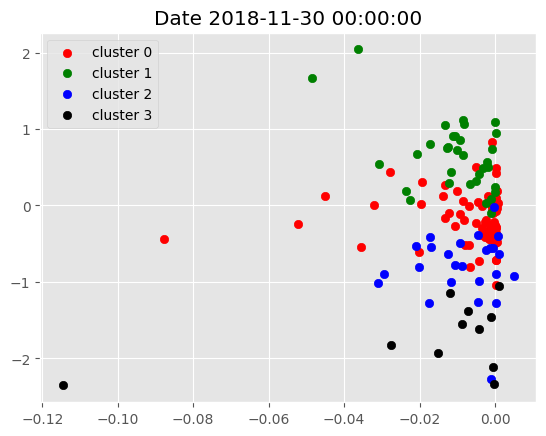

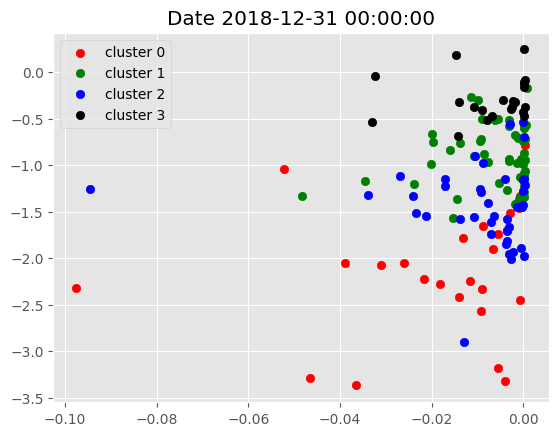

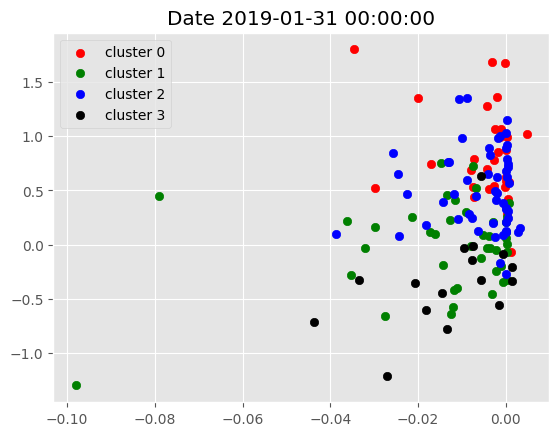

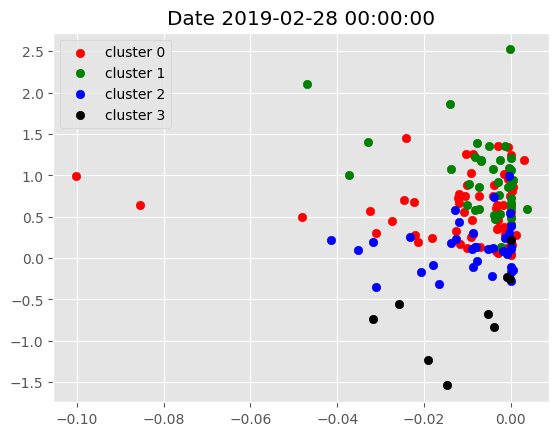

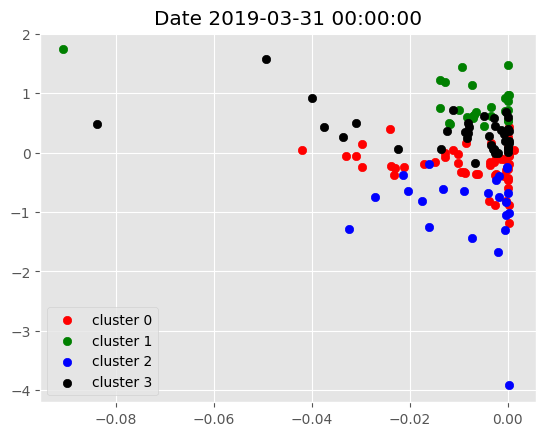

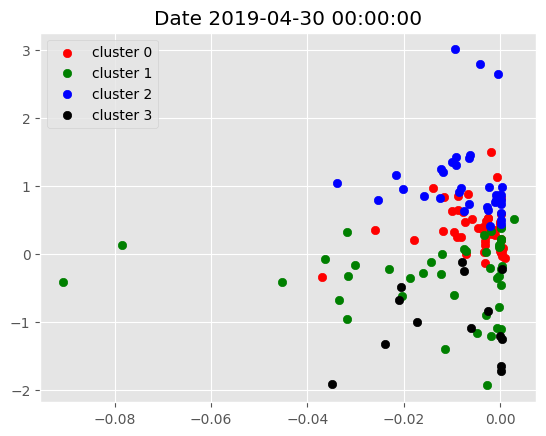

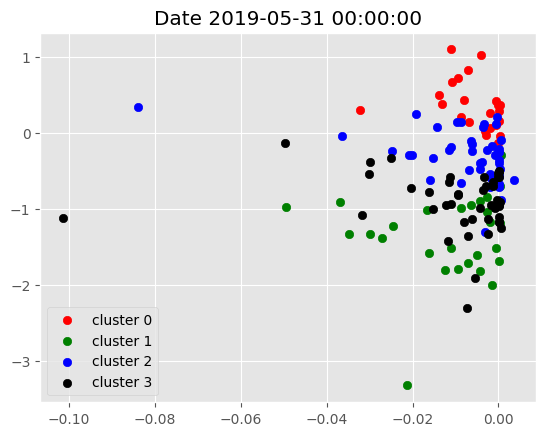

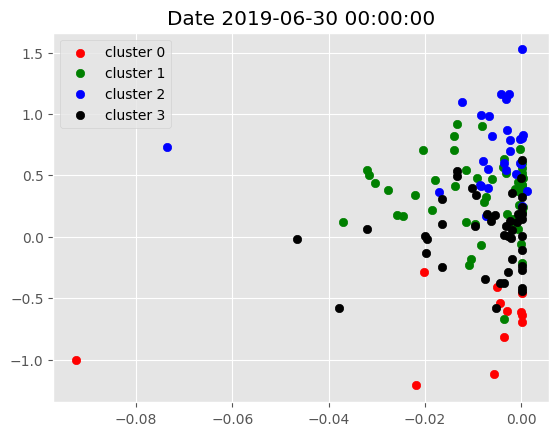

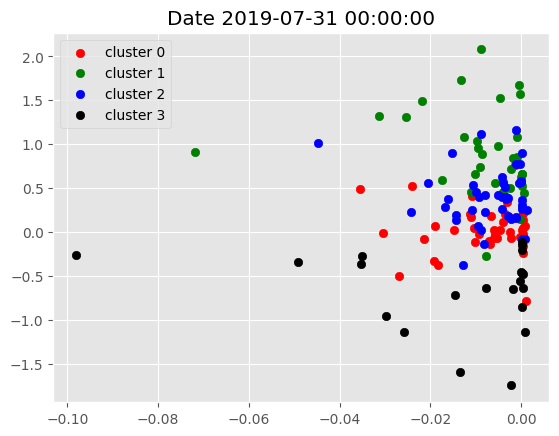

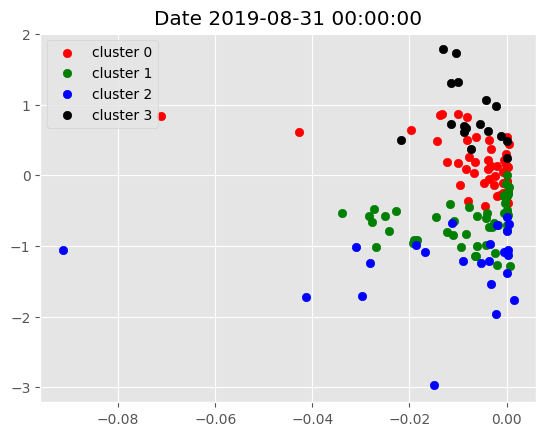

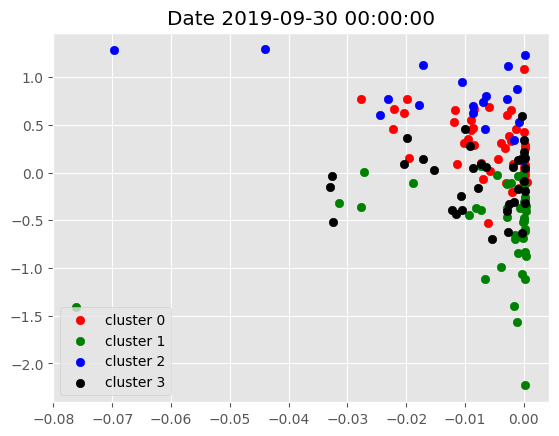

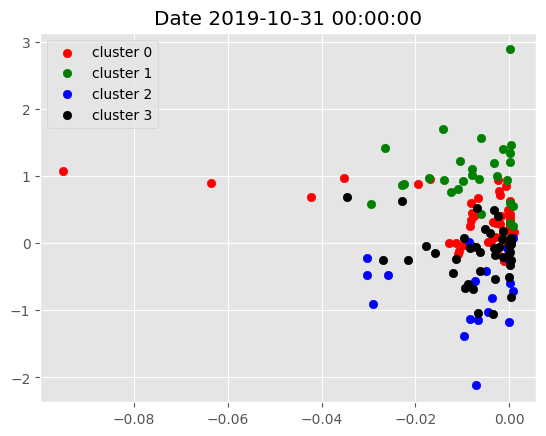

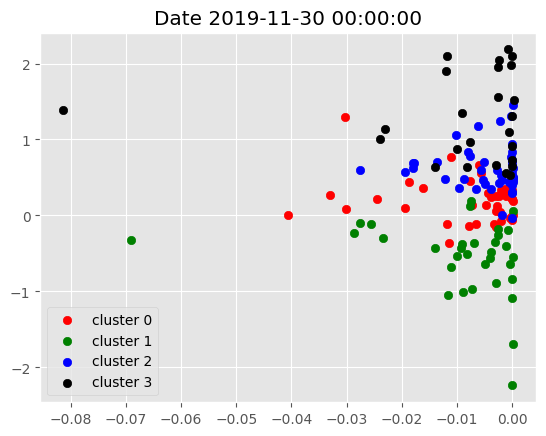

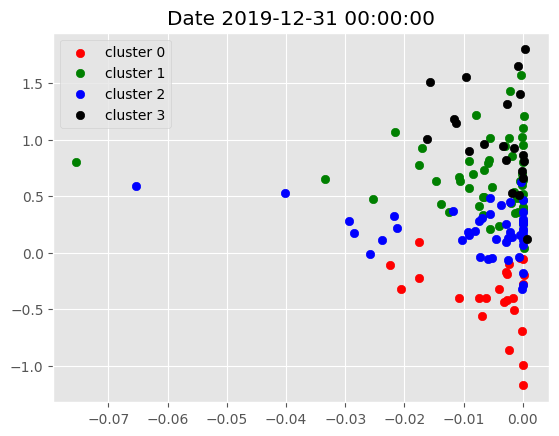

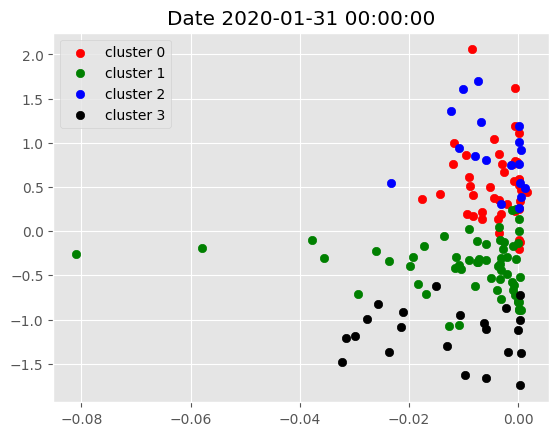

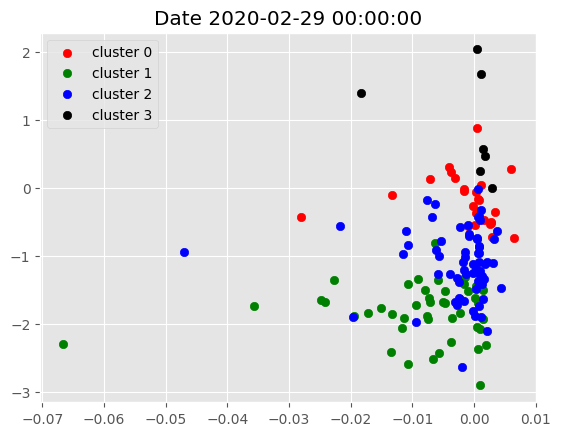

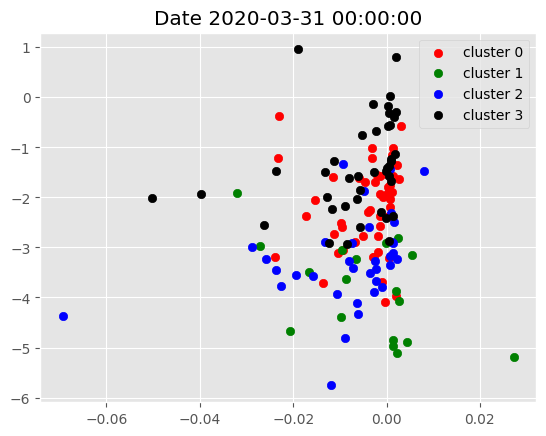

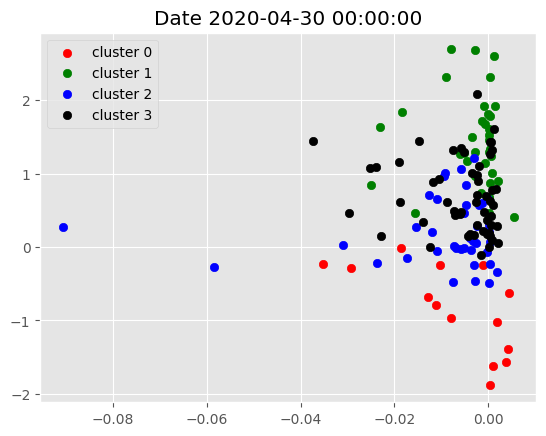

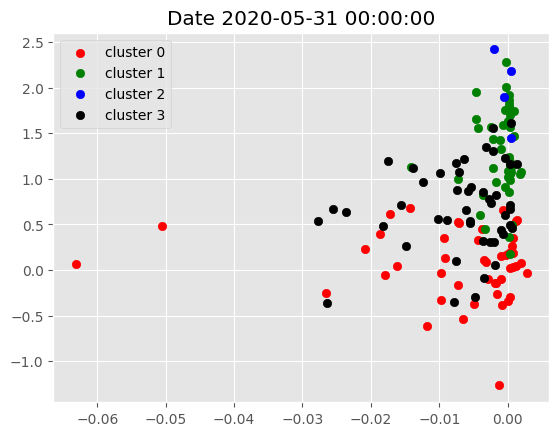

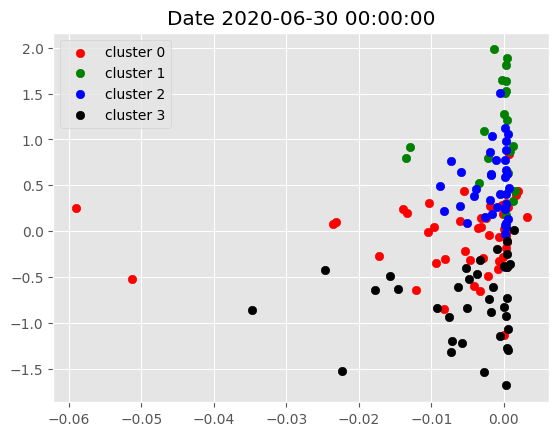

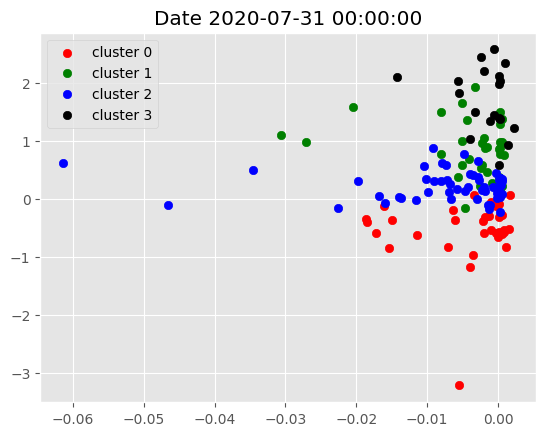

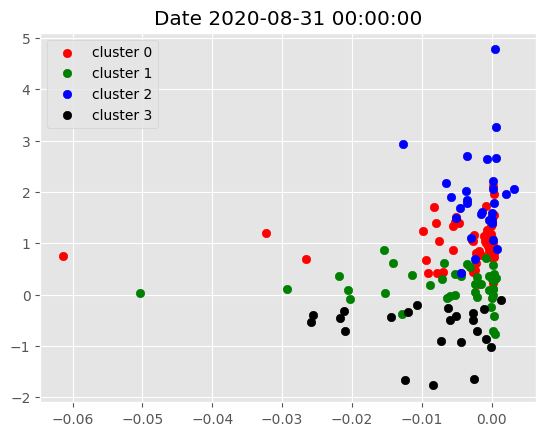

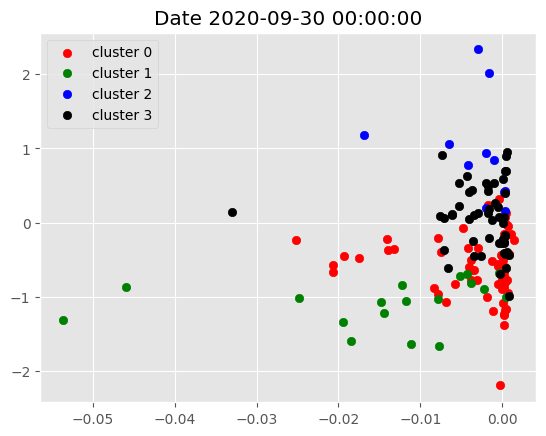

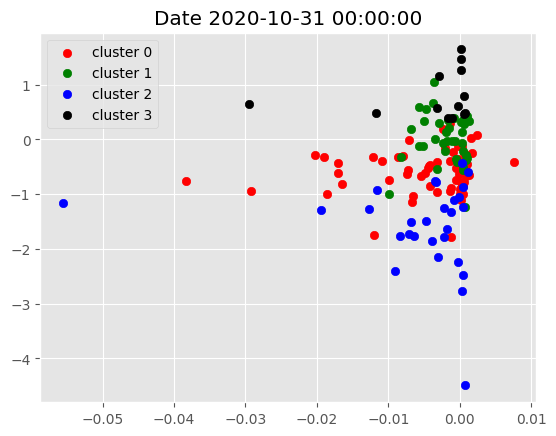

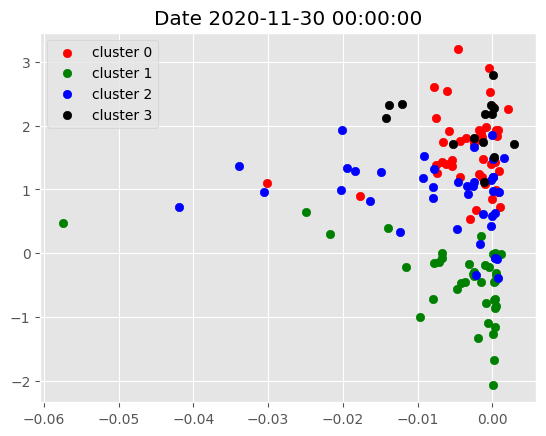

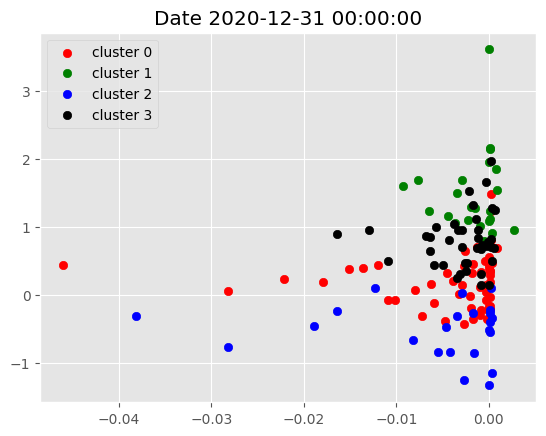

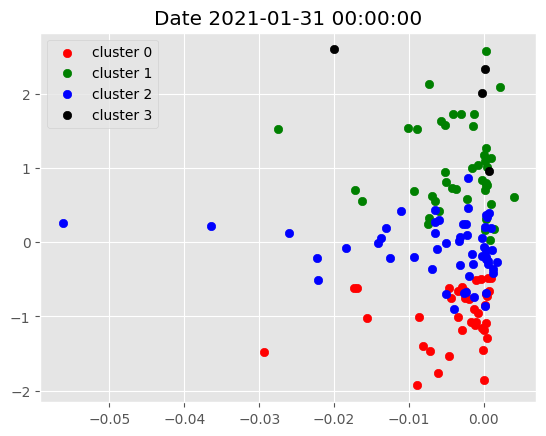

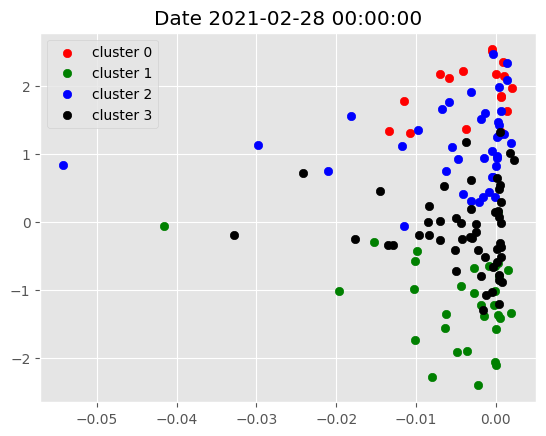

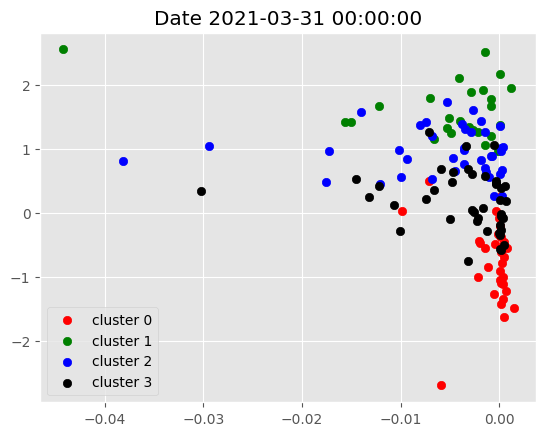

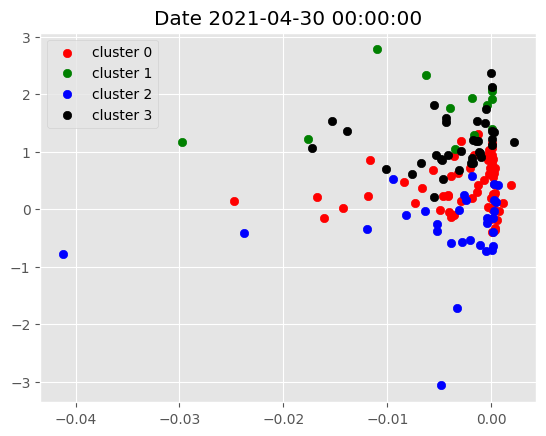

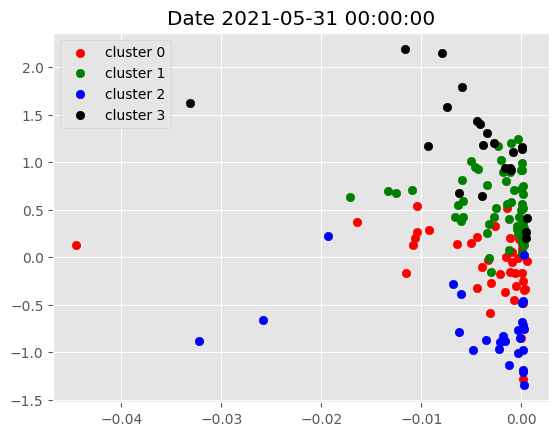

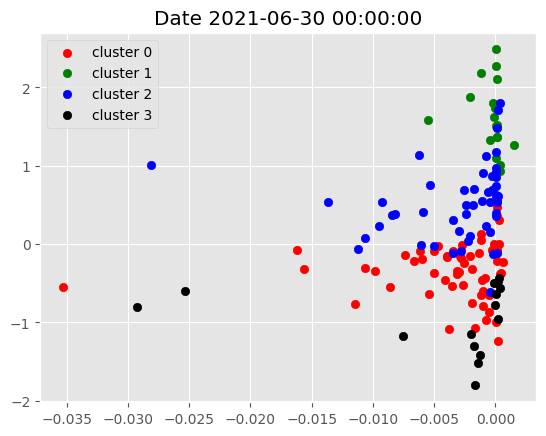

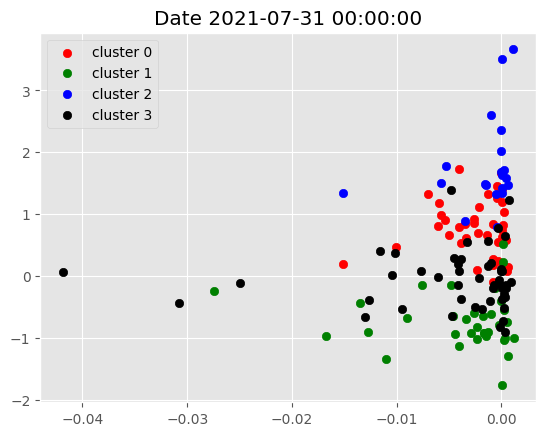

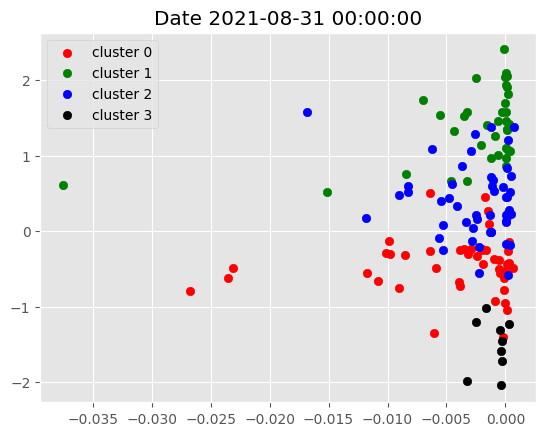

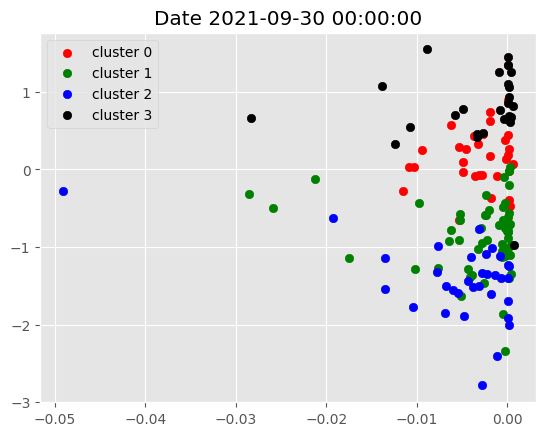

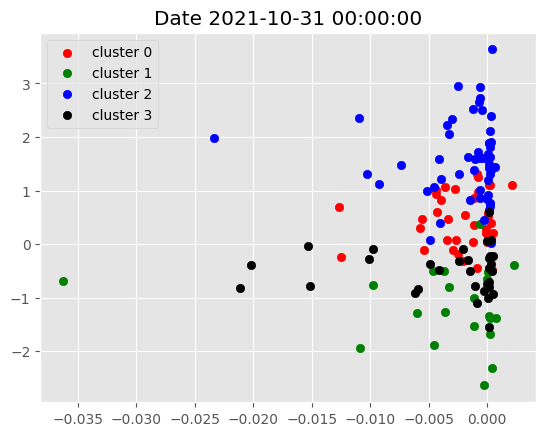

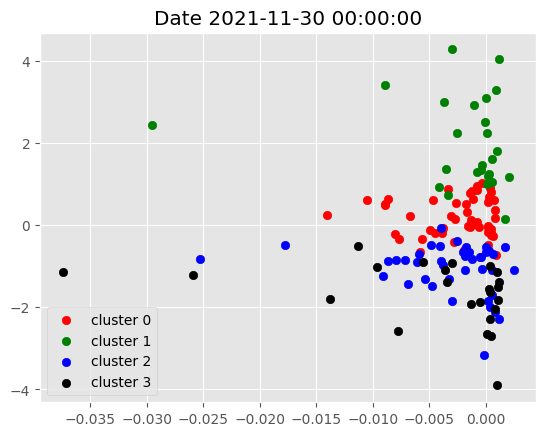

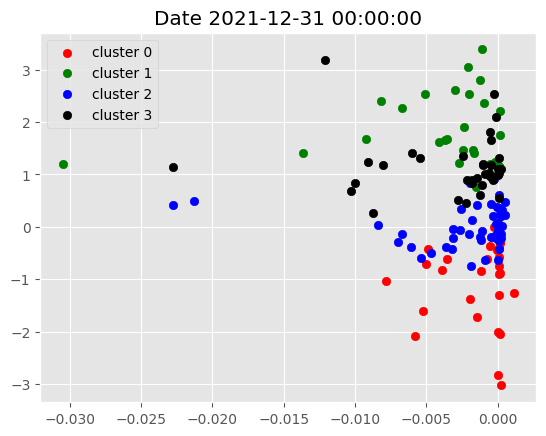

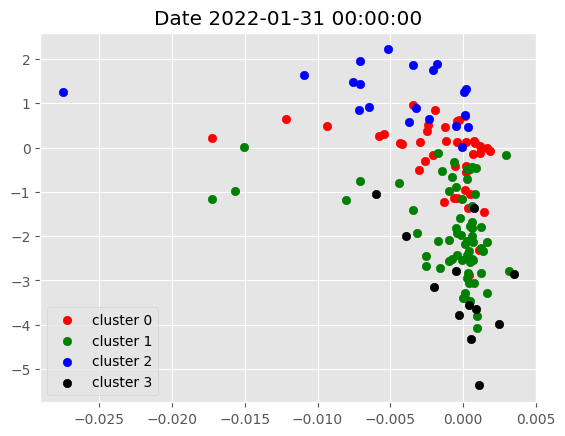

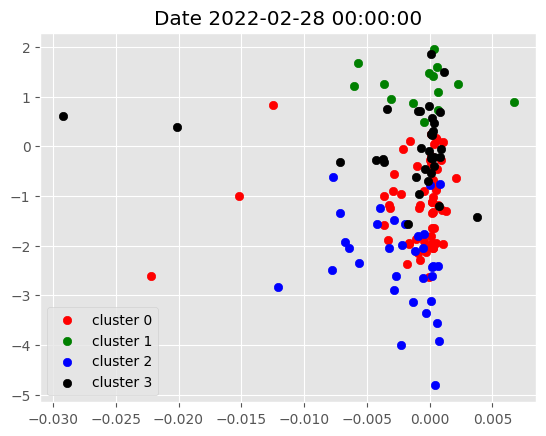

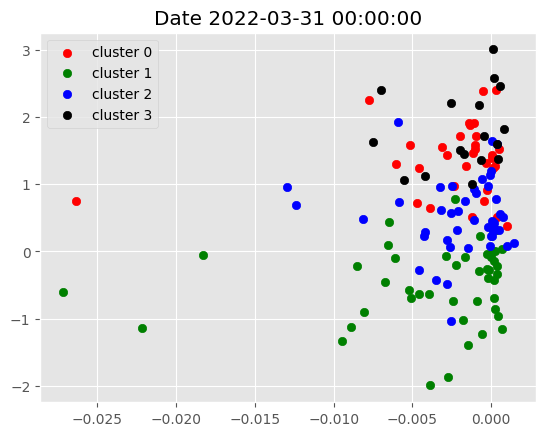

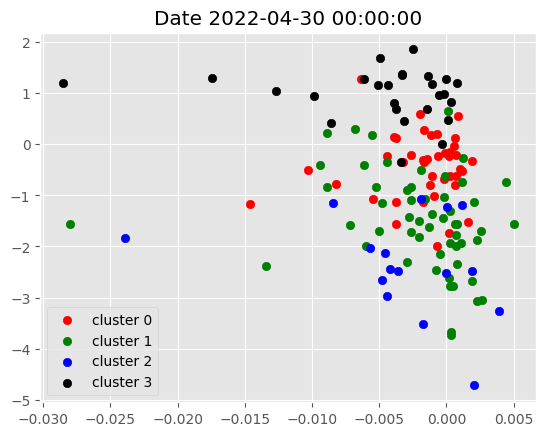

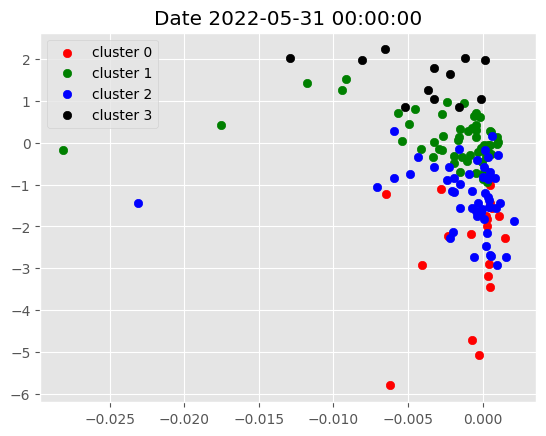

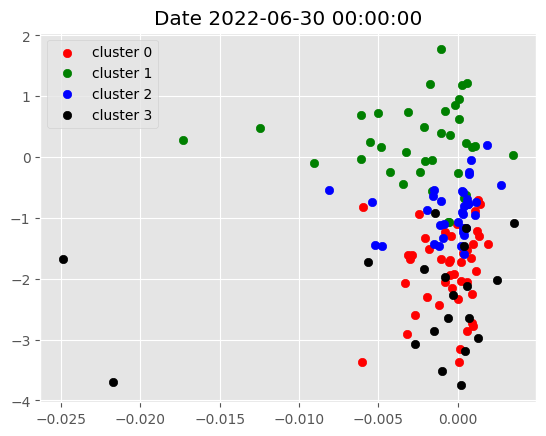

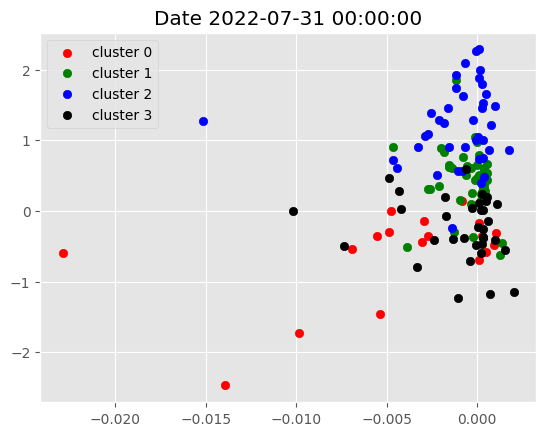

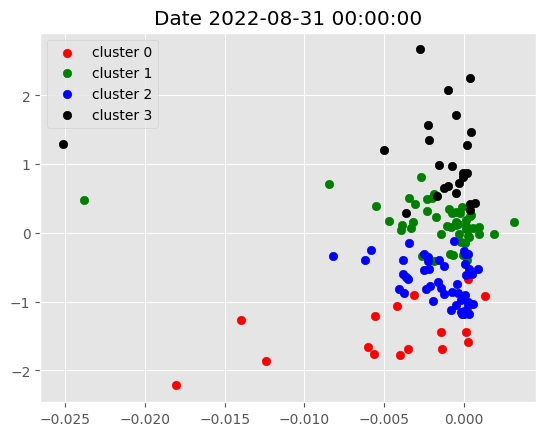

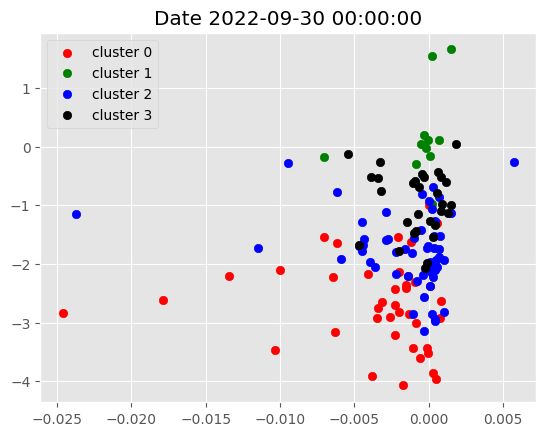

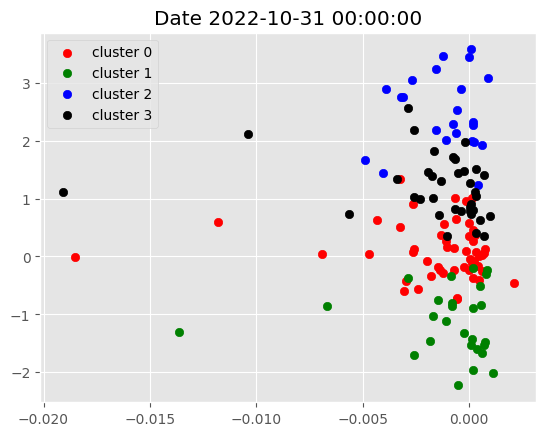

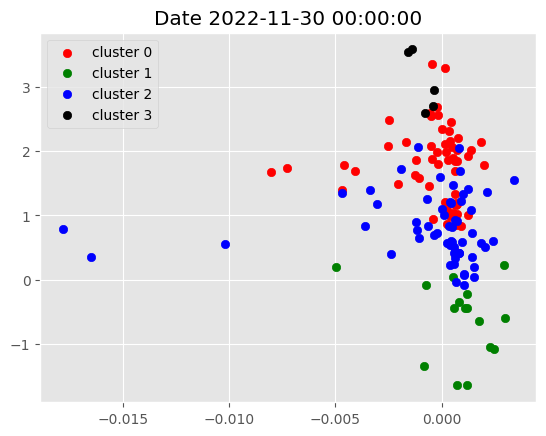

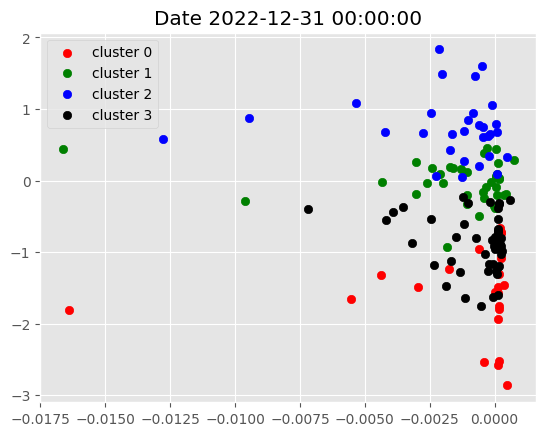

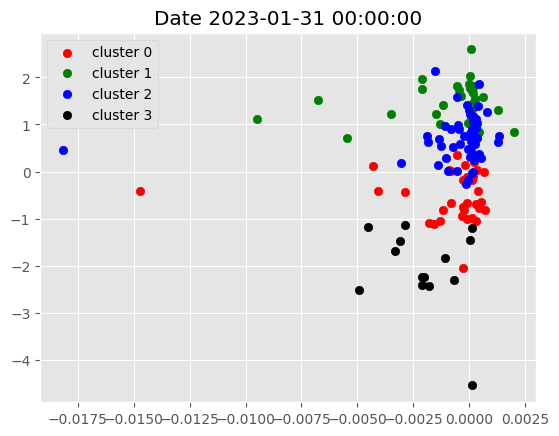

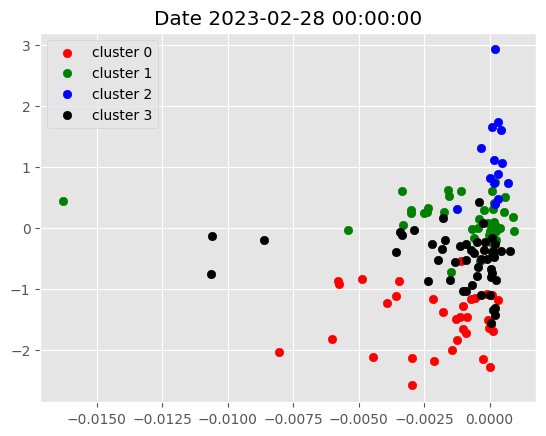

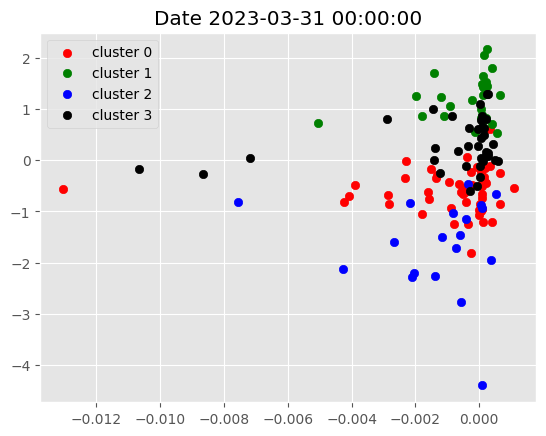

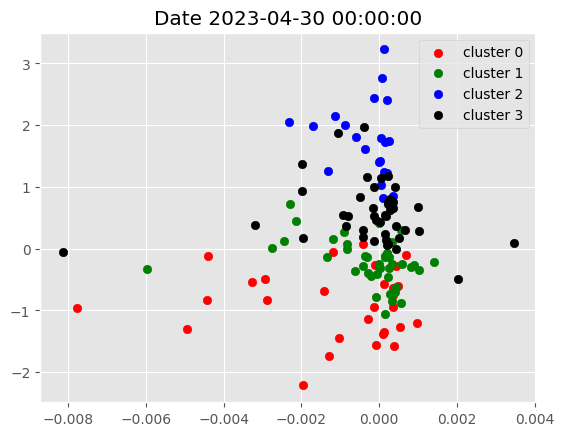

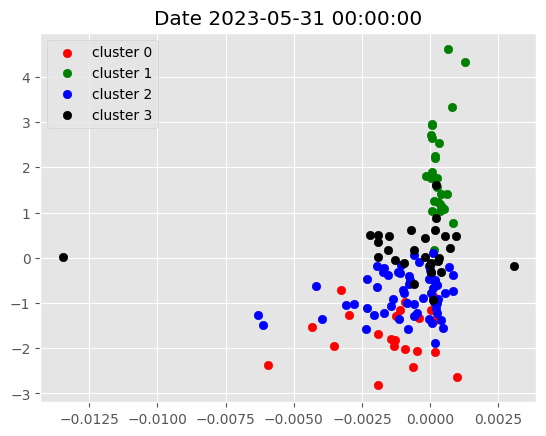

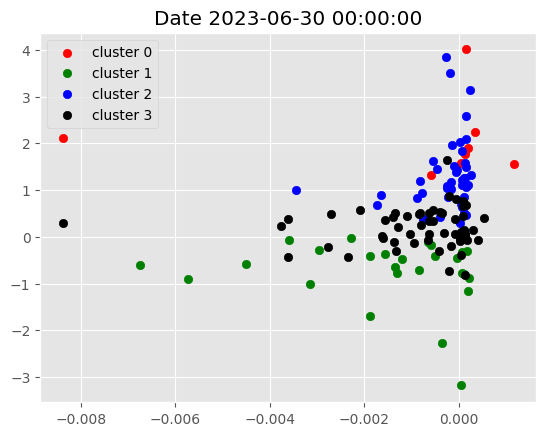

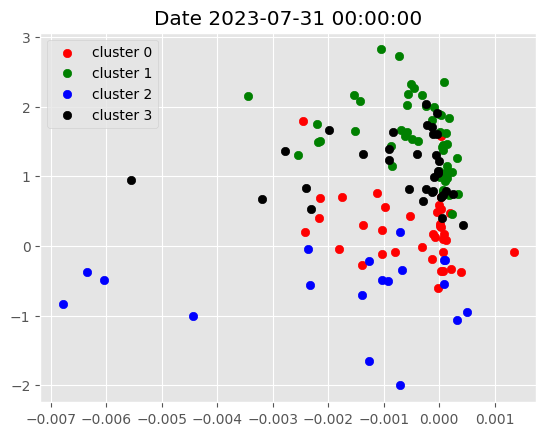

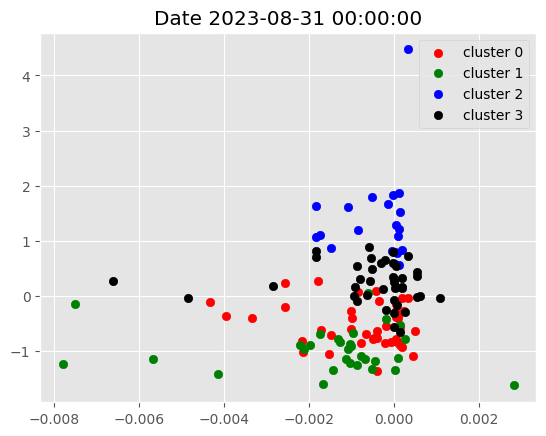

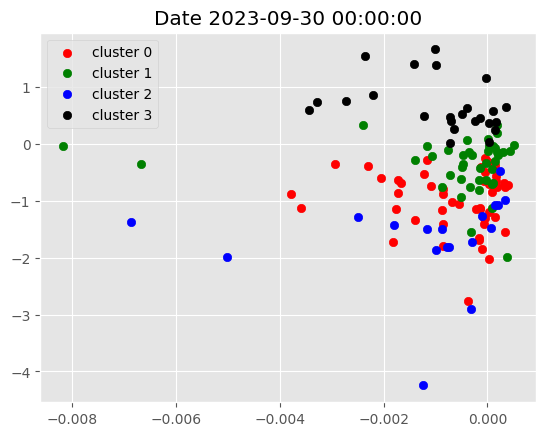

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

### Apply pre-defined centroids.

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-11-01': ['ABBV',
  'ABT',
  'AZO',
  'BA',
  'BIIB',
  'BKNG',
  'BMY',
  'BRK-B',
  'C',
  'CCL',
  'COST',
  'CVX',
  'DAL',
  'DG',
  'EA',
  'EBAY',
  'FDX',
  'GM',
  'GS',
  'HAL',
  'HON',
  'IBM',
  'JNJ',
  'KO',
  'KR',
  'LMT',
  'LOW',
  'MDLZ',
  'MDT',
  'MO',
  'MS',
  'NFLX',
  'NKE',
  'ORLY',
  'OXY',
  'PANW',
  'RTX',
  'SBUX',
  'SCHW',
  'TGT',
  'TMO',
  'UNP',
  'UPS',
  'USB',
  'VZ',
  'WDC',
  'WYNN'],
 '2017-12-01': ['AXP',
  'AZO',
  'BA',
  'BLK',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'MAR',
  'MMM',
  'NKE',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ABBV',
  'ADBE',
  'AMZN',
  'BIIB',
  'C',
  'CCL',
  'CHTR',
  'CSX',
  'CVS',
  'DD',
  'DHR',
  'DIS',
  'EBAY',
  'ELV',
  'F',
  'GD',
  'GOOG',
  'GOOGL',
  'GS',
  'HUM',
  'IBM',
  'JNJ',
  'KO',
  'MA',
  'MCD',
  'MCK',
  'MDLZ',
  'MDT',
  'META',
  'MMM',
  'MRK',
  'MS',
  'NEE',
  'NFLX',
  'NOC',
  'ORLY',
  'PANW

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [ ]:
!pip install PyPortfolioOpt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 13.8 MB/s eta 0:00:00


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  156 of 156 completed


Price            Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2016-10-31   26.060881   38.501820  33.469261  101.253769  107.510002   
2016-11-01   25.590347   38.964291  33.307198  101.166656  106.870003   
2016-11-02   25.613295   39.198971  33.008675  103.318222  105.889999   
2016-11-03   25.338755   38.577755  32.735729  101.872231  107.169998   
2016-11-04   25.110348   38.681286  33.341309  102.116135  106.199997   
...                ...         ...        ...         ...         ...   
2023-09-25  174.372040  143.755920  93.684288  306.312988  511.600006   
2023-09-26  170.292007  143.068069  92.492447  300.147888  506.299988   
2023-09-27  168.776825  142.343033  91.819633  303.790985  502.600006   
2023-09-28  169.034317  141.524994  94.309036  290.639343  504.670013   
2023-09-29  169.549271  138.559723  93.088356  296.765778  509.899994   

Price                                                                  ...  \
Ticker             ADP        ADSK        AIG        AMAT         AMD  ...   
Date                                                                   ...   
2016-10-31   72.332809   72.279999  49.409813   26.281977    7.230000  ...   
2016-11-01   72.216499   70.099998  48.592999   26.119291    7.090000  ...   
2016-11-02   74.758850   68.680000  48.488884   25.839127    6.760000  ...   
2016-11-03   74.218811   67.610001  46.566940   25.549910    6.700000  ...   
2016-11-04   74.011101   69.440002  45.950336   25.504723    6.560000  ...   
...                ...         ...        ...         ...         ...  ...   
2023-09-25  231.056625  205.669998  59.895290  134.163193   97.379997  ...   
2023-09-26  228.380478  201.660004  59.056576  131.697800   95.959999  ...   
2023-09-27  233.569168  202.279999  58.815571  132.660385   98.070000  ...   
2023-09-28  234.223785  207.889999  59.075855  135.764236  102.760002  ...   
2023-09-29  231.595734  206.910004  58.420311  135.990143  102.820000  ...   

Price        Volume                                                            \
Ticker         VRTX        VZ       WBA     WDAY      WDC       WFC       WMT   
Date                                                                            
2016-10-31  1928200  12459400   4662100  1147300  4449514  20115900  19167000   
2016-11-01  2458200  13229400   5130800  1091400  5055315  20020200  26515800   
2016-11-02  2580400  16488200   9783100  1127800  5578033  19566600  22935900   
2016-11-03  2371000  12605100   4586500   633300  4223810  14982700  20411700   
2016-11-04  1902100  14410200   7023900   892600  3579509  27391600  21786300   
...             ...       ...       ...      ...      ...       ...       ...   
2023-09-25   698100  17616900   6891000   894200  3553446  10624000  10459500   
2023-09-26   633600  18841600   7570500  1217300  4724565  15219400  14435700   
2023-09-27   860600  22083500  10182900  2338100  3370739  11815500  15711000   
2023-09-28   578900  18772100   7291500  9196300  4342086  12454600  11617200   
2023-09-29   896800  19787600  25663400  4066600  3323376  13124500  18842400   

Price                                    
Ticker         WYNN       XOM       XYZ  
Date                                     
2016-10-31  1341600  16663800   2960600  
2016-11-01  3722300  13050600   8190900  
2016-11-02  2542400  11226100  19503200  
2016-11-03  9050400   8836500   7371500  
2016-11-04  3223800  13877100  13462800  
...             ...       ...       ...  
2023-09-25  1387800  11316000   8841300  
2023-09-26  1454000  11805400  10168200  
2023-09-27  2050000  23976200  11656100  
2023-09-28  1290400  16808100  16585100  
2023-09-29  1326800  18813600  11965300  

[1740 rows x 780 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [ ]:
import numpy as np
import pandas as pd

# Step 1: Calculate daily returns for all stocks in your universe
price_data = new_df['Close'] if 'Close' in new_df else new_df['close']  # adjust column name if needed
daily_returns = price_data.pct_change().dropna(how='all')  # drop rows where all returns are NaN

# Step 2: Prepare your monthly rebalance dates (assume first trading day of each month)
monthly_rebalance_dates = daily_returns.resample('MS').first().index

# Prepare an empty DataFrame to store portfolio returns
portfolio_returns = pd.Series(dtype=float)

# Loop over each rebalance date except the last one (since weights are for next month)
for i in range(len(monthly_rebalance_dates) - 1):
    rebalance_date = monthly_rebalance_dates[i]
    next_month_start = monthly_rebalance_dates[i+1]

    # Stocks selected for the month, from your filtered_df dictionary or data:
    # Here I'm assuming you have 'fixed_dates' dict mapping date string -> tickers list
    date_str = rebalance_date.strftime('%Y-%m-%d')
    if date_str not in fixed_dates:
        # No stocks selected, skip this month
        continue

    selected_stocks = fixed_dates[date_str]

    # Filter daily returns for selected stocks and dates between next month start and the month after
    try:
        # Get price data of selected stocks for next month period
        if i + 2 < len(monthly_rebalance_dates):
            next_month_end = monthly_rebalance_dates[i+2] - pd.Timedelta(days=1)
        else:
            next_month_end = daily_returns.index[-1]

        # Subset returns for next month and selected stocks
        returns_next_month = daily_returns.loc[next_month_start:next_month_end, selected_stocks].dropna(axis=1, how='all')

        if returns_next_month.empty:
            continue

        # Optimize weights based on price data until rebalance_date (historical lookback)
        lookback_start = rebalance_date - pd.DateOffset(months=12)
        lookback_prices = price_data.loc[lookback_start:rebalance_date, selected_stocks].dropna(axis=1, how='all')

        if lookback_prices.shape[1] == 0:
            continue

        # Try max Sharpe optimization
        try:
            weights = optimize_weights(lookback_prices)
            weights = pd.Series(weights)
            # Keep weights only for stocks present in returns_next_month
            weights = weights[weights.index.isin(returns_next_month.columns)]

            # Normalize weights to sum to 1 (in case some stocks are missing)
            weights /= weights.sum()
        except Exception:
            print(f"Max Sharpe Optimization failed for {rebalance_date.strftime('%Y-%m-%d')}, Continuing with Equal-Weights")
            weights = pd.Series(1 / len(returns_next_month.columns), index=returns_next_month.columns)

        # Calculate portfolio daily returns for next month
        # Align columns (stocks) between returns and weights
        weights = weights.reindex(returns_next_month.columns).fillna(0)
        daily_portfolio_returns = returns_next_month.dot(weights)

        # Append to overall portfolio returns
        portfolio_returns = pd.concat([portfolio_returns, daily_portfolio_returns])
    except Exception as e:
        print(f"Unexpected error for {rebalance_date.strftime('%Y-%m-%d')}: {e}")
        continue

# Sort portfolio returns by date (index)
portfolio_returns = portfolio_returns.sort_index()

# Output
print(portfolio_returns.to_frame(name='Strategy Return').head())


Max Sharpe Optimization failed for 2018-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-12-01, Continuing with Equal-Weights
            Strategy Return
2017-12-01        -0.004575
2017-12-04        -0.002532
2017-12-05        -0.001079
2017-12-06        -0.000645
2017-12-07         0.000564


In [ ]:
print(portfolio_df.index.nlevels)
print(portfolio_df.index)
print(spy_ret.index.nlevels)
print(spy_ret.index)


1
DatetimeIndex(['2017-12-01', '2017-12-04', '2017-12-05', '2017-12-06',
               '2017-12-07', '2017-12-08', '2017-12-11', '2017-12-12',
               '2017-12-13', '2017-12-14',
               ...
               '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21',
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29'],
              dtype='datetime64[ns]', length=1466, freq=None)
1
DatetimeIndex(['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14',
               '2015-01-15', '2015-01-16',
               ...
               '2025-05-19', '2025-05-20', '2025-05-21', '2025-05-22',
               '2025-05-23', '2025-05-27', '2025-05-28', '2025-05-29',
               '2025-05-30', '2025-06-02'],
              dtype='datetime64[ns]', name='Date', length=2618, freq=None)


In [ ]:
print(spy_ret.columns)


MultiIndex([('SPY Buy&Hold', 'SPY')],
           names=['Price', 'Ticker'])


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

print("[*********************100%**********************]  1 of 1 completed")

# Download SPY data for the full portfolio period
start_date = portfolio_returns.index.min()
end_date = portfolio_returns.index.max()

spy = yf.download("SPY", start=start_date, end=end_date)

# Calculate daily log returns for SPY
spy_ret = np.log(spy['Close']).diff().dropna()
spy_ret.name = 'SPY Buy&Hold'

# Align SPY returns dates with portfolio returns
# Merge portfolio returns and SPY returns into a DataFrame on the index (date)
combined_returns = pd.concat(
    [portfolio_returns.rename('Strategy Return'), spy_ret],
    axis=1
).dropna()

print(combined_returns.head())

# Optionally, you can visualize like this (requires matplotlib):
# import matplotlib.pyplot as plt
# combined_returns.cumsum().plot(title='Cumulative Returns: Strategy vs SPY')
# plt.show()


[*********************100%**********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

            Strategy Return       SPY
2017-12-04        -0.002532 -0.001211
2017-12-05        -0.001079 -0.003603
2017-12-06        -0.000645  0.000190
2017-12-07         0.000564  0.003148
2017-12-08         0.006922  0.005438


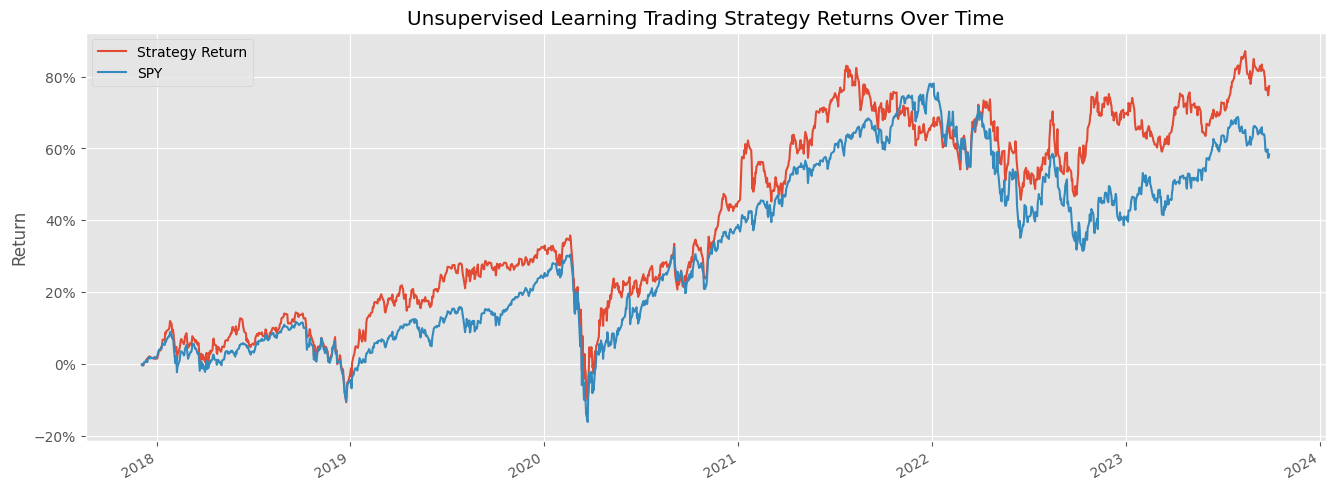

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

plt.style.use('ggplot')

# Correct cumulative return calculation:
# Step 1: log(1 + daily_return)
# Step 2: cumulative sum of log returns (log of cumulative product)
# Step 3: exponentiate and subtract 1 to get cumulative return
portfolio_cumulative_return = np.exp(np.log1p(combined_returns).cumsum()) - 1

# Plot cumulative returns up to the date '2023-09-29'
portfolio_cumulative_return.loc[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()
